In [1]:
import torch
from torchvision import transforms, models
import torch.nn as nn
from torch.utils.data import DataLoader
import random
from tqdm import tqdm
from vcs2425 import ApplyColormap, evaluate_topk, load_dataset_splits

# 1. Reproducibility
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)

# 2. Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

color_map_transform = ApplyColormap(cmap='viridis')

# 3. Transforms
train_transform = transforms.Compose([
    transforms.Resize((342, 342), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop((299, 299)),
    color_map_transform,
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((342, 342), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop((299, 299)),
    color_map_transform,
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [2]:
# 4. Load full dataset
_, val_dataset = load_dataset_splits('../../ILSVRC2012_depth', train_transform, val_transform)

BATCH_SIZE = 64

# 7. DataLoaders
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE, 
    shuffle=False,
)

# Evaluating "as-is"

In [3]:
model = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1)

model.to(device)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [4]:
top_1s = []
top_5s = []

colormaps = ['stacked', 'gray', 'viridis', 'plasma', 'magma', 'Spectral']
criterion = nn.CrossEntropyLoss()

for cmap in tqdm(colormaps, desc="Evaluating on different colormaps"):
    color_map_transform.cmap = cmap

    top_1 = evaluate_topk(model, val_loader, k=1, device=device)
    top_5 = evaluate_topk(model, val_loader, k=5, device=device)
    
    top_1s.append(top_1)
    top_5s.append(top_5)
    
    print(f"Colormap: {cmap}, Top-1 Accuracy: {top_1:.4f}, Top-5 Accuracy: {top_5:.4f}")



Evaluating on different colormaps:  17%|█▋        | 1/6 [01:55<09:35, 115.19s/it]

Colormap: stacked, Top-1 Accuracy: 0.1648, Top-5 Accuracy: 0.3305


Evaluating on different colormaps:  33%|███▎      | 2/6 [04:12<08:32, 128.22s/it]

Colormap: gray, Top-1 Accuracy: 0.1640, Top-5 Accuracy: 0.3294


Evaluating on different colormaps:  50%|█████     | 3/6 [06:27<06:33, 131.26s/it]

Colormap: viridis, Top-1 Accuracy: 0.1316, Top-5 Accuracy: 0.2666


Evaluating on different colormaps:  67%|██████▋   | 4/6 [08:42<04:25, 132.87s/it]

Colormap: plasma, Top-1 Accuracy: 0.1236, Top-5 Accuracy: 0.2534


Evaluating on different colormaps:  83%|████████▎ | 5/6 [10:58<02:13, 133.87s/it]

Colormap: magma, Top-1 Accuracy: 0.1501, Top-5 Accuracy: 0.3007


Evaluating on different colormaps: 100%|██████████| 6/6 [13:15<00:00, 132.63s/it]

Colormap: Spectral, Top-1 Accuracy: 0.1039, Top-5 Accuracy: 0.2279


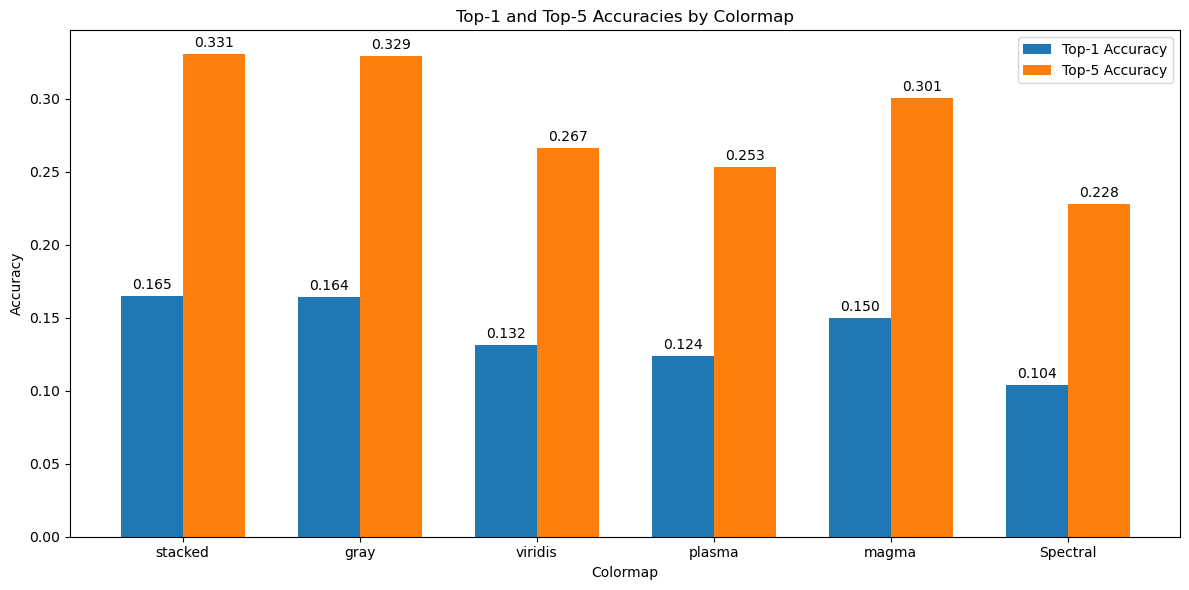

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Create a figure for the grid
fig, ax = plt.subplots(figsize=(12, 6))

# Set up bar width and positions
x = np.arange(len(colormaps))
width = 0.35

# Create bars
rects1 = ax.bar(x - width/2, top_1s, width, label='Top-1 Accuracy')
rects2 = ax.bar(x + width/2, top_5s, width, label='Top-5 Accuracy')

# Add labels, title and legend
ax.set_xlabel('Colormap')
ax.set_ylabel('Accuracy')
ax.set_title('Top-1 and Top-5 Accuracies by Colormap')
ax.set_xticks(x)
ax.set_xticklabels(colormaps)
ax.legend()

# Add text labels on top of bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()